# Lecture 29: Cross Validation



[Acknowledgments Page](https://ds100.org/fa23/acks/)

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In this lecture, we will work with the `vehicles` dataset.

In [2]:
vehicles = sns.load_dataset("mpg").rename(columns={"horsepower":"hp"}).dropna().sort_values("hp")
vehicles.head()

,mpg,cylinders,displacement,hp,weight,acceleration,model_year,origin,name
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel)
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel)
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel


Suppose we want to use the `hp` (horsepower) of a car to predict its `mpg` (gas mileage in miles per gallon). If we visualize the relationship between these two variables, we see a non-linear curvature. Fitting a linear model to these variables results in a high (poor) value of RMSE. 

$$\hat{y} = \theta_0 + \theta_1 (\text{hp})$$

RMSE of model with (hp) feature: 4.893226230065712


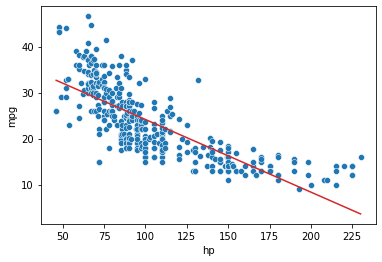

In [4]:
import sklearn.linear_model as lm


X = vehicles[["hp"]]
y = vehicles["mpg"]


hp_model = lm.LinearRegression()
hp_model.fit(X, y)
hp_model_predictions = hp_model.predict(X)

sns.scatterplot(data=vehicles, x="hp", y="mpg")

plt.plot(vehicles["hp"], hp_model_predictions, c="tab:red");

print(f"RMSE of model with (hp) feature: {np.sqrt(np.mean((y-hp_model_predictions)**2))}")

To capture the non-linear relationship between the variables, we can introduce a non-linear feature: `hp` squared. Our new model is:

$$\hat{y} = \theta_0 + \theta_1 (\text{hp}) + \theta_2 (\text{hp}^2)$$

RMSE of model with (hp^2) feature: 4.357151467141951


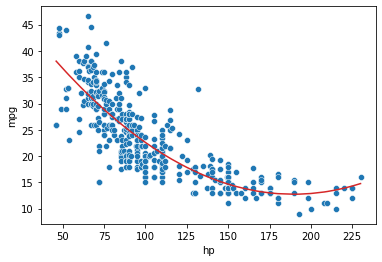

In [5]:
X = vehicles[["hp"]]
X.loc[:, "hp^2"] = vehicles["hp"]**2

hp2_model = lm.LinearRegression()
hp2_model.fit(X, y)
hp2_model_predictions = hp2_model.predict(X)

sns.scatterplot(data=vehicles, x="hp", y="mpg")

plt.plot(vehicles["hp"], hp2_model_predictions, c="tab:red");

print(f"RMSE of model with (hp^2) feature: {np.sqrt(np.mean((y-hp2_model_predictions)**2))}")

What if we take things further and add even *more* polynomial features?


For example, a degree 4 polynomial based on the `hp` feature to predict `mpg` can be characterized as follows:

$$\widehat{mpg} = \theta_0 + \theta_1 hp + \theta_2 hp^2 + \theta_3 hp^3 + \theta_4 hp^4$$

The cell below fits models of increasing complexity and computes their MSEs.

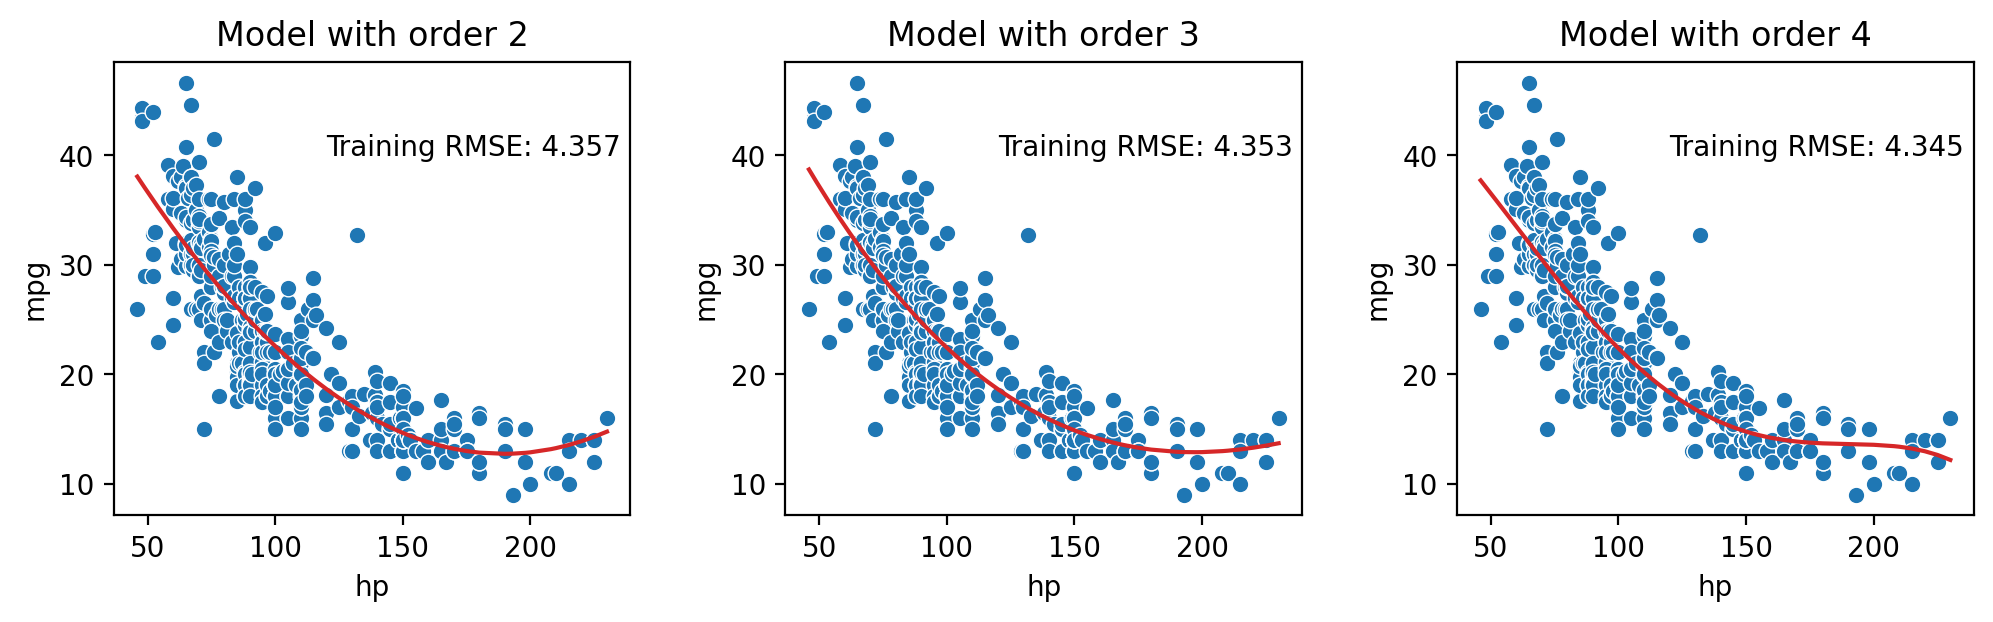

In [6]:
def mse(predictions, observations):
    return np.mean((observations - predictions)**2)



# Add hp^3 and hp^4 as features to the data
X["hp^3"] = vehicles["hp"]**3
X["hp^4"] = vehicles["hp"]**4

# Fit a model with order 3
hp3_model = lm.LinearRegression()
hp3_model.fit(X[["hp", "hp^2", "hp^3"]], vehicles["mpg"])
hp3_model_predictions = hp3_model.predict(X[["hp", "hp^2", "hp^3"]])

# Fit a model with order 4
hp4_model = lm.LinearRegression()
hp4_model.fit(X[["hp", "hp^2", "hp^3", "hp^4"]], vehicles["mpg"])
hp4_model_predictions = hp4_model.predict(X[["hp", "hp^2", "hp^3", "hp^4"]])

# Plot the models' predictions
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

predictions_dict = {0:hp2_model_predictions, 1:hp3_model_predictions, 2:hp4_model_predictions}

for i in predictions_dict:
    ax[i].scatter(vehicles["hp"], vehicles["mpg"], edgecolor="white", lw=0.5)
    ax[i].plot(vehicles["hp"], predictions_dict[i], "tab:red")
    ax[i].set_title(f"Model with order {i+2}")
    ax[i].set_xlabel("hp")
    ax[i].set_ylabel("mpg")
    ax[i].annotate(f"Training RMSE: {np.round(np.sqrt(mse(vehicles['mpg'], predictions_dict[i])), 3)}", (120, 40))

plt.subplots_adjust(wspace=0.3);

## Complexity and Overfitting

What we saw above was the phenomenon of **model complexity** – as we add additional features to the design matrix, the model becomes increasingly *complex*. Models with higher complexity have lower values of training error. Intuitively, this makes sense: with more features at its disposal, the model can match the observations in the trainining data more and more closely. 

We can run an experiment to see this in action. In the cell below, we fit many models of progressively higher complexity, then plot the MSE of predictions on the training set. The code used (specifically, the `Pipeline` and `PolynomialFeatures` functions of `sklearn`) is just for efficiency - this code is out of scope of CSCI 3022.

The **order** of a polynomial model is the highest power of any term in the model. An order 0 model takes the form $\hat{y} = \theta_0$, while an order 4 model takes the form $\hat{y} = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 + \theta_4 x^4$.

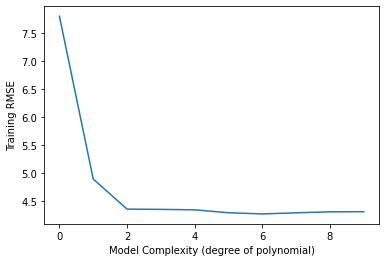

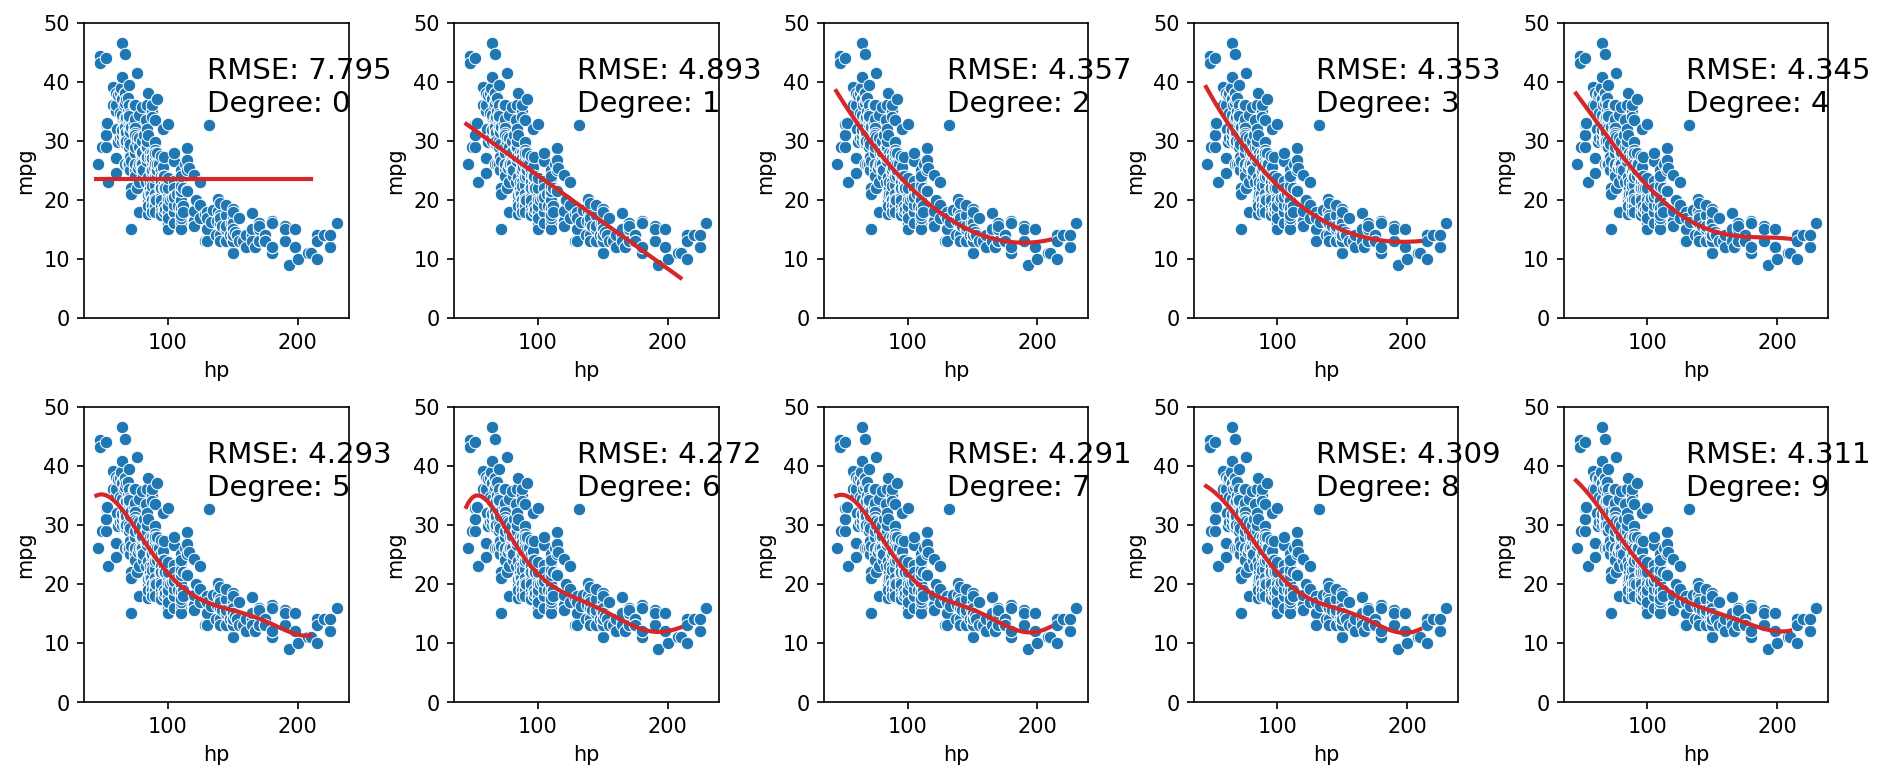

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_model_dataset(degree, dataset):
    pipelined_model = Pipeline([
            ('polynomial_transformation', PolynomialFeatures(degree)),
            ('linear_regression', lm.LinearRegression())    
        ])

    pipelined_model.fit(dataset[["hp"]], dataset["mpg"])
    return np.sqrt(mse(dataset['mpg'], pipelined_model.predict(dataset[["hp"]])))

errors = [fit_model_dataset(degree, vehicles) for degree in range(0, 10)]
RMSEs_and_k = pd.DataFrame({"k": range(0, 10), "RMSE": errors})

plt.plot(range(0, 10), errors)
plt.xlabel("Model Complexity (degree of polynomial)")
plt.ylabel("Training RMSE");

def plot_degree_k_model(k, RMSEs_and_k, axs):
    pipelined_model = Pipeline([
        ('poly_transform', PolynomialFeatures(degree = k)),
        ('regression', lm.LinearRegression(fit_intercept = True))    
    ])
    pipelined_model.fit(vehicles[["hp"]], vehicles["mpg"])
    
    row = k // 5
    col = k % 5
    ax = axs[row, col]
    
    sns.scatterplot(data=vehicles, x='hp', y='mpg', ax=ax)
    
    x_range = np.linspace(45, 210, 100).reshape(-1, 1)
    ax.plot(x_range, pipelined_model.predict(pd.DataFrame(x_range, columns=['hp'])), c='tab:red', linewidth=2)
    
    ax.set_ylim((0, 50))
    mse_str = f"RMSE: {RMSEs_and_k.loc[k, 'RMSE']:.4}\nDegree: {k}"
    ax.text(130, 35, mse_str, dict(size=14))

fig = plt.figure(figsize=(15, 6), dpi=150)
axs = fig.subplots(nrows=2, ncols=5)

for k in range(10):
    plot_degree_k_model(k, RMSEs_and_k, axs)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

As the model increases in polynomial degree (that is, it increases in complexity), the training RMSE decreases, plateauing at roughly ~4.3.

In fact, it is a mathematical fact that if we create a polynomial model with degree $n-1$, we can *perfectly* model a set of $n$ points (assuming all $n$ points describe a function). For example, a set of 5 points can be perfectly modeled by a degree 4 model.

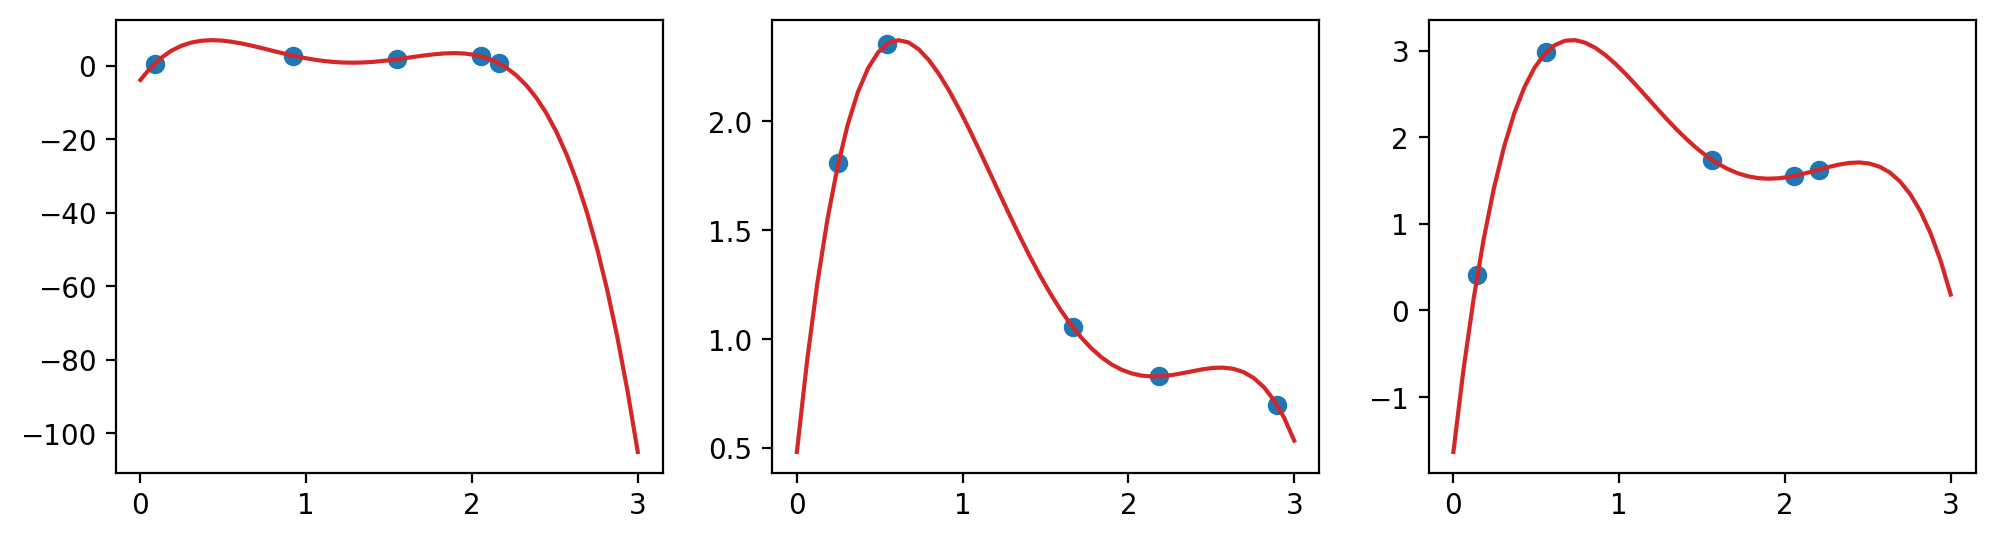

In [8]:
np.random.seed(101)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for i in range(0, 3):
    points = 3*np.random.uniform(size=(5, 2))

    polynomial_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(4)),
                ('linear_regression', lm.LinearRegression())    
            ])

    polynomial_model.fit(points[:, [0]], points[:, 1])

    ax[i].scatter(points[:, 0], points[:, 1])

    xs = np.linspace(0, 3)
    ax[i].plot(xs, polynomial_model.predict(xs[:, np.newaxis]), c="tab:red");

You may be tempted to always design models with high polynomial degree – after all, we know that we could theoretically achieve perfect predictions by creating a model with enough polynomial features. 

It turns out that the examples we looked at above represent a somewhat artificial scenario: we trained our model on all the data we had available, then used the model to make predictions on this very same dataset. A more realistic situation is when we wish to apply our model on unseen data – that is, datapoints that it did not encounter during the model fitting process. 


# Cross Validation

## Train-Test-Validation Split

The first thing we will want to do with this data is construct a train/test/validation split. Constructing a train/test/validation test split before EDA and data cleaning can often be helpful.  This allows us to see if our data cleaning and any conclusions we draw from visualizations generalize to new data. This can be done by re-running the data cleaning and EDA process on the test dataset.

Let's set aside 20% of our data for testing, and then further split the remaining 80% into 80% and 20% for training and validation 

In [9]:
def train_val_test_split(data):
    """ 
    Takes in a DataFrame `data` and randomly splits it into three smaller DataFrames 
    named 'test', `train` and `validation` with 20% and 64% and 16% of the data, respectively. 
    """

    data_len = data.shape[0]

    shuffled_indices = np.random.permutation(data_len)
    
    
    # Set train equal to the first 64%  of shuffled_indices
    train_indices = shuffled_indices[:int(data_len * 0.64)]
    # Set valid equal to the next 16% of shuffled_indices
    validation_indices = shuffled_indices[int(data_len * 0.64):int(data_len*.80)]
    # Set test equal to the last 20% of shuffled_indices
    test_indices = shuffled_indices[int(data_len * 0.8):]

    
    
    train = data.iloc[train_indices] 
    validation = data.iloc[validation_indices] 
    test = data.iloc[test_indices]
    
    return train, validation, test

In [10]:
np.random.seed(100)

train, valid, test = train_val_test_split(vehicles)

Checking that they add up.

In [12]:
len(train) + len(test) +len(valid) == len(vehicles)

True

In [11]:
print("length of training set:", len(train))
print("length of validation set:", len(valid))
print("length of testing set:", len(test))


length of training set: 250
length of validation set: 63
length of testing set: 79


### Train/Test/Validation Split Using SKLearn

We can use the `train_test_split` function from `sklearn.model_selection` to do this easily.

In [13]:

from sklearn.model_selection import train_test_split

# `test_size` specifies the proportion of the full dataset that should be allocated to testing.
# `random_state` makes our results reproducible for educational purposes.
# shuffle is True by default and randomizes the data before splitting.


X = vehicles


Y = vehicles["mpg"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=100, 
                                                    shuffle=True)

print(f"Size of full dataset: {X.shape[0]} points")
print(f"Size of training set: {X_train.shape[0]} points")
print(f"Size of test set: {X_test.shape[0]} points")


# Split X_train further into X_train_mini and X_val.
X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=13)

print(f"Size of original training set: {X_train.shape[0]} points")
print(f"Size of mini training set: {X_train_mini.shape[0]} points")
print(f"Size of validation set: {X_val.shape[0]} points")


Size of full dataset: 392 points
Size of training set: 313 points
Size of test set: 79 points
Size of original training set: 313 points
Size of mini training set: 250 points
Size of validation set: 63 points


## Fitting Models Using Training Data and Evaluating RMSE Using Validation Data

In the cell below, we fit several models of increasing complexity (using the training data), then compute their errors. Here, we find the model's errors on the **validation set** to understand how model complexity influences performance on unseen data.

Outline of code below:

1. Fit an degree-x model to the mini training set
2. Evaluate the fitted model's RMSE when making predictions on the validation set

We use the model's performance on the validation set as a guide to selecting the best combination of features. We are not limited in the number of times we use the validation set – we just never use this set to fit the model.


The code below uses `Pipelines` in scikit-learn.  For the scope of CSCI 3022 this semester, you do not need to know how to use sci-kit learn's `Pipeline` class - it is quite involved. Fortunately, they are merely an accessory to the concepts of this lecture, and not the core of it. If you treat each instance of a `Pipeline` as a black-box way of specifying which features our model should have, you will be able to understand the cross-validation content just fine.

If you're interested, you can [skim the documentation on pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline).


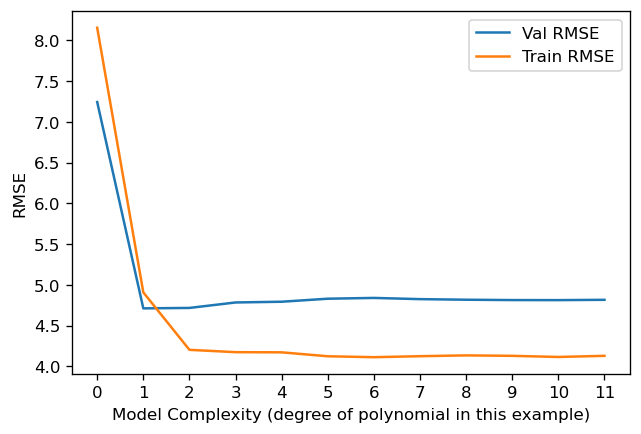

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def fit_model_dataset(degree):
    pipelined_model = Pipeline([
            ('polynomial_transformation', PolynomialFeatures(degree)),
            ('linear_regression', lm.LinearRegression())    
        ])

    pipelined_model.fit(X_train_mini[["hp"]], Y_train_mini)
    training_error = np.sqrt(mse(pipelined_model.predict(X_train_mini[["hp"]]), Y_train_mini))
    validation_error = np.sqrt(mse(pipelined_model.predict(X_val[["hp"]]), Y_val))
    return [degree, training_error, validation_error]
    
    
    
ks = np.array(range(0, 12))
RMSEs = [fit_model_dataset(k) for k in ks]
RMSEs_and_k = pd.DataFrame(RMSEs, columns = ['Degree', 'Training RMSE', 'Validation RMSE'])
RMSEs_and_k
    



plt.figure(dpi=120)
plt.plot(RMSEs_and_k["Degree"], RMSEs_and_k["Validation RMSE"], label="Val RMSE")
plt.plot(RMSEs_and_k["Degree"], RMSEs_and_k["Training RMSE"], label = "Train RMSE")
plt.xlabel("Model Complexity (degree of polynomial in this example)")
plt.ylabel("RMSE")
plt.xticks(range(0, 12));
plt.legend()




In [15]:
RMSEs_and_k.rename(columns={"k":"Degree"}).set_index("Degree")

,Training RMSE,Validation RMSE
Degree,,
0,8.154821,7.243653
1,4.908544,4.712324
2,4.203574,4.717603
3,4.174890,4.784624
4,4.172910,4.793630
5,4.124614,4.830694
6,4.113244,4.840292
7,4.125440,4.825464
8,4.135367,4.818280


From this **model selection** process, we might choose to create a model with degree 1 (it gives the lowest validation RMSE)

It's possible that we may have, by random chance, selected a set of validation points that was *not* representative of other unseen data that the model might encounter (for example, if we happened to have selected all outlying data points for the validation set).


Different train/validation splits lead to different validation errors:

In [17]:
# Examine different validation errors for the 2nd degree model:
for i in range(1, 4):
    X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
    X_train_mini["hp^2"] = X_train_mini["hp"]
    X_train_mini = X_train_mini[["hp", "hp^2"]]
    model = lm.LinearRegression()
    model.fit(X_train_mini, Y_train_mini)
    
    X_val["hp^2"] = X_val["hp"]
    X_val = X_val[["hp", "hp^2"]] 
    y_hat = model.predict(X_val)
    print(f"Val error from train/validation split #{i}: {np.sqrt(mse(y_hat, Y_val))}")

Val error from train/validation split #1: 4.48306513175741
Val error from train/validation split #2: 5.053365750939568
Val error from train/validation split #3: 4.330459860059803


## A more complete process: K-Fold Cross-Validation

The validation set gave us an opportunity to understand how the model performs on a **single** set of unseen data. The specific validation set we drew was fixed – we used the same vali

To apply cross-validation, we use the `KFold` class of `sklearn.model_selection`. `KFold` will return the indices of each cross-validation fold. Then, we iterate over each of these folds to designate it as the validation set, while training the model on the remaining folds.

In [30]:
from sklearn.model_selection import KFold
np.random.seed(25) # Ensures reproducibility of this notebook


# n_splits sets the number of folds to create
kf = KFold(n_splits=5, shuffle=True)

for train_idx, valid_idx in kf.split(X):
    print(train_idx[:5])

[0 1 2 3 4]
[0 1 2 3 5]
[2 4 5 6 8]
[0 1 2 3 4]
[0 1 3 4 5]


## Let's do cross validation for each of the orders (up to order 6):

In [34]:
from sklearn.model_selection import KFold
np.random.seed(25)

def train_with_crossvalidation(degree, folds):
    
    # n_splits sets the number of folds to create
    
    kf = KFold(n_splits=folds, shuffle=True)
    validation_errors = []

    X = train[["hp"]] 
    Y = train["mpg"]
    
    model = Pipeline([
        ('transform', PolynomialFeatures(degree = degree)),
        ('regression', LinearRegression(fit_intercept = True))    
    ])
    for train_idx, valid_idx in kf.split(X):
        # Split the data
        split_X_train, split_X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y.iloc[train_idx], Y.iloc[valid_idx]
      
        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        error = np.sqrt(mse(model.predict(split_X_valid), split_Y_valid))

        validation_errors.append(error)
    return np.mean(validation_errors)

In [36]:
np.random.seed(25)
ks = np.array(range(0, 7))
folds = np.array(range(2, 6))
RMSEs_CV = pd.DataFrame(columns = ['k', 'folds', 'Ave RMSE'])

for k in ks:
    for f in folds:
        RMSEs_CV = RMSEs_CV.append({'k': k, 'folds': f, 'Ave RMSE': train_with_crossvalidation(k, f)}, 
                       ignore_index=True)

RMSEs_CV['k'] = RMSEs_CV['k'].astype('int')
RMSEs_CV['folds'] = RMSEs_CV['folds'].astype('int')

RMSEs_CV

,k,folds,Ave RMSE
0,0,2,7.830174
1,0,3,7.776725
2,0,4,7.759012
3,0,5,7.736964
4,1,2,4.80741
5,1,3,4.863534
6,1,4,4.853496
7,1,5,4.815094
8,2,2,4.234826
9,2,3,4.329597


In [37]:
RMSEs_CV[RMSEs_CV["folds"]==5]

,k,folds,Ave RMSE
3,0,5,7.736964
7,1,5,4.815094
11,2,5,4.252054
15,3,5,4.228186
19,4,5,4.286347
23,5,5,4.200462
27,6,5,4.207036


In [38]:
# Looking into RMSEs for different degree polynomials
RMSEs_CV.groupby("k")["Ave RMSE"].mean().to_frame()

,Ave RMSE
k,
0,7.775719
1,4.834884
2,4.285466
3,4.306082
4,4.364233
5,4.273112
6,4.457549


## Conclusion: This k-fold cross validation confirms that for this dataset, we would choose a 2nd order model

# After Model Selection, use training and validation sets to fit the final model: 
 typically use the entire training set (both the "mini" training set and validation set) to fit the final model.

In [39]:
# Once we've used the validation set to determine the highest order of the polynomial, 
# we can create our FINAL model using all of the training data

# This is where you apply your feature processing to get the final version of inputs for your model:

# Create the input Design Matrix (here we're using polynomial of degree 2)
X_train["hp^2"] = X_train["hp"]**2
X_train = X_train[["hp", "hp^2"]]



final_model = lm.LinearRegression()
final_model.fit(X_train, Y_train)

LinearRegression()

## Use the test data set (ONCE), to get your FINAL result
After this choice has been finalized, and we are completely finished with the model design process, we finally assess model performance (ONCE) on the test set.

In [41]:

X_test["hp^2"] = X_test["hp"]**2
X_test = X_test[["hp", "hp^2"]]

print(f"Test RMSE of final model: {np.sqrt(mse(Y_test, final_model.predict(X_test)))}")



Test RMSE of final model: 4.623522080196269
